In [1]:
import pandas as pd
import numpy as np 
import altair as alt
from altair import datum
import geopandas as gpd
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

import random


import baltic as bt


import datetime
from datetime import datetime as dt
from datetime import timedelta


import math
import time
import sys
import unicodedata

import numpy as np
from scipy.interpolate import UnivariateSpline ## used to smooth counts of lineages in each location at any given time
from scipy.interpolate import interp1d ## used to linearly interpolate between data points used in colouring polygons
from sklearn.decomposition import IncrementalPCA ## used to identify PCA1 when automatically producing a colour map
    


from Bio import Phylo

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [141]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction


In [168]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [2]:
#need to convert the decimal dates back to calendar dates 
def convert_partial_year(number):

    year = int(number)
    d = timedelta(days=(number - year)*(365 + is_leap(year)))
    day_one = dt(year,1,1)
    date = d + day_one
    date = dt.strftime(date, '%Y-%m-%d')
    return date

In [3]:
def is_leap(number):
    if number == 2024:
        leap = 1
    else:
        leap = 0
    return leap

In [4]:
def convert_format(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = date - timedelta(days=date.weekday())
    return date

In [68]:
#read in cluster information
sub_meta = pd.read_csv("../multitree_coalescent/data/la_clusters_with_metadata_10_07.tsv", sep = "\t")
sub_meta.head()

In [71]:
#format dates

sub_meta["year_month"] = sub_meta['date'].str.rsplit("-", 1).str[-0].tolist()
sub_meta["year"] = sub_meta['date'].str.rsplit("-", 0).str[-0].tolist()

#sub_meta = sub_meta[sub_meta.year_month.str.contains('XX*')==False]
sub_meta = sub_meta[sub_meta.year_month > "2022-01"]

#sub_meta['calendar_date'] = sub_meta.date.map(convert_partial_year)
sub_meta['year-week'] = sub_meta['date'].map(convert_format)


In [76]:
# read in empirical mpox case data
la_mpox_cases_df = pd.read_csv("../scripts/monkeypox_data.csv")
la_mpox_cases_df = la_mpox_cases_df.dropna(how = "all").dropna(axis = "columns", how = "all")
la_mpox_cases_df = la_mpox_cases_df.rename(columns= {"Unnamed: 0": "date"}); la_mpox_cases_df.head()

,date,cases
0,2022-05-19,1
1,2022-05-20,0
2,2022-05-21,0
3,2022-05-22,0
4,2022-05-23,0


In [77]:
#format dates
weekly_cases = la_mpox_cases_df.copy()
weekly_cases.date = pd.to_datetime(weekly_cases['date'])
weekly_cases = weekly_cases.set_index("date")
weekly_cases = weekly_cases.resample("W").sum()
weekly_cases.head()

,cases
date,
2022-05-22,1
2022-05-29,0
2022-06-05,4
2022-06-12,9
2022-06-19,18


In [78]:
combined_genomes_cases = pd.merge(sub_meta, la_mpox_cases_df, on= "date", how= "left")

In [163]:
#more date formatting 
la_mpox_cases_df.date = pd.to_datetime(la_mpox_cases_df['date'])
la_mpox_cases_df["decimal_date"] =la_mpox_cases_df.date.map(toYearFraction)


sub_meta.date = pd.to_datetime(sub_meta['date'])
sub_meta["decimal_date"] =sub_meta.date.map(toYearFraction)

sub_meta['count'] = sub_meta.groupby('date')['date'].transform('count')


In [181]:
#read in simulation data
sim_df = pd.read_csv("../data/results_sep13_2024.csv")
sim_df["week"] = sim_df.date.str.rsplit(" ", 0).str[2].tolist()
sim_df = sim_df.dropna()
sim_df.week = pd.to_datetime(sim_df['week'])
sim_df["decimal_date"] =sim_df.week.map(toYearFraction)
sim_df.head()

,date,Empirical # of diagnosed cases,Model (FoI=1) diagnosed cases,Model (FoI=1) incidence,Model (FoI=1) symp,Model (FoI=1) R_e,Model (FoI=1.25) diagnosed cases,Model (FoI=1.25) incidence,Model (FoI=1.25) symp,Model (FoI=1.25) R_e,Model (FoI=1.5) diagnosed cases,Model (FoI=1.5) incidence,Model (FoI=1.5) symp,Model (FoI=1.5) R_e,Model (FoI=2) diagnosed cases,Model (FoI=2) incidence,week,decimal_date
1,7/10/22 - 7/16/22,125,123.0,140.0,279.0,2.320441989,123.0,140.0,279.0,2.320442,123.0,140.0,279.0,2.320442,123.0,140.0,2022-07-16,2022.536872
2,7/17/22 - 7/23/22,185,179.0,249.0,392.0,2.677419355,179.0,249.0,392.0,2.677419,179.0,249.0,392.0,2.677419,179.0,249.0,2022-07-23,2022.556050
3,7/24/22 - 7/30/22,221,202.0,302.0,495.0,2.31122449,202.0,302.0,495.0,2.311224,202.0,302.0,495.0,2.311224,202.0,302.0,2022-07-30,2022.575228
4,7/31/22 - 8/6/22,264,226.0,391.0,619.0,2.36969697,226.0,391.0,619.0,2.369697,226.0,391.0,619.0,2.369697,226.0,391.0,2022-08-06,2022.594406
5,8/7/22 - 8/13/22,261,258.0,143.0,645.0,0.693053312,258.0,143.0,645.0,0.693053,258.0,143.0,645.0,0.693053,258.0,143.0,2022-08-13,2022.613584


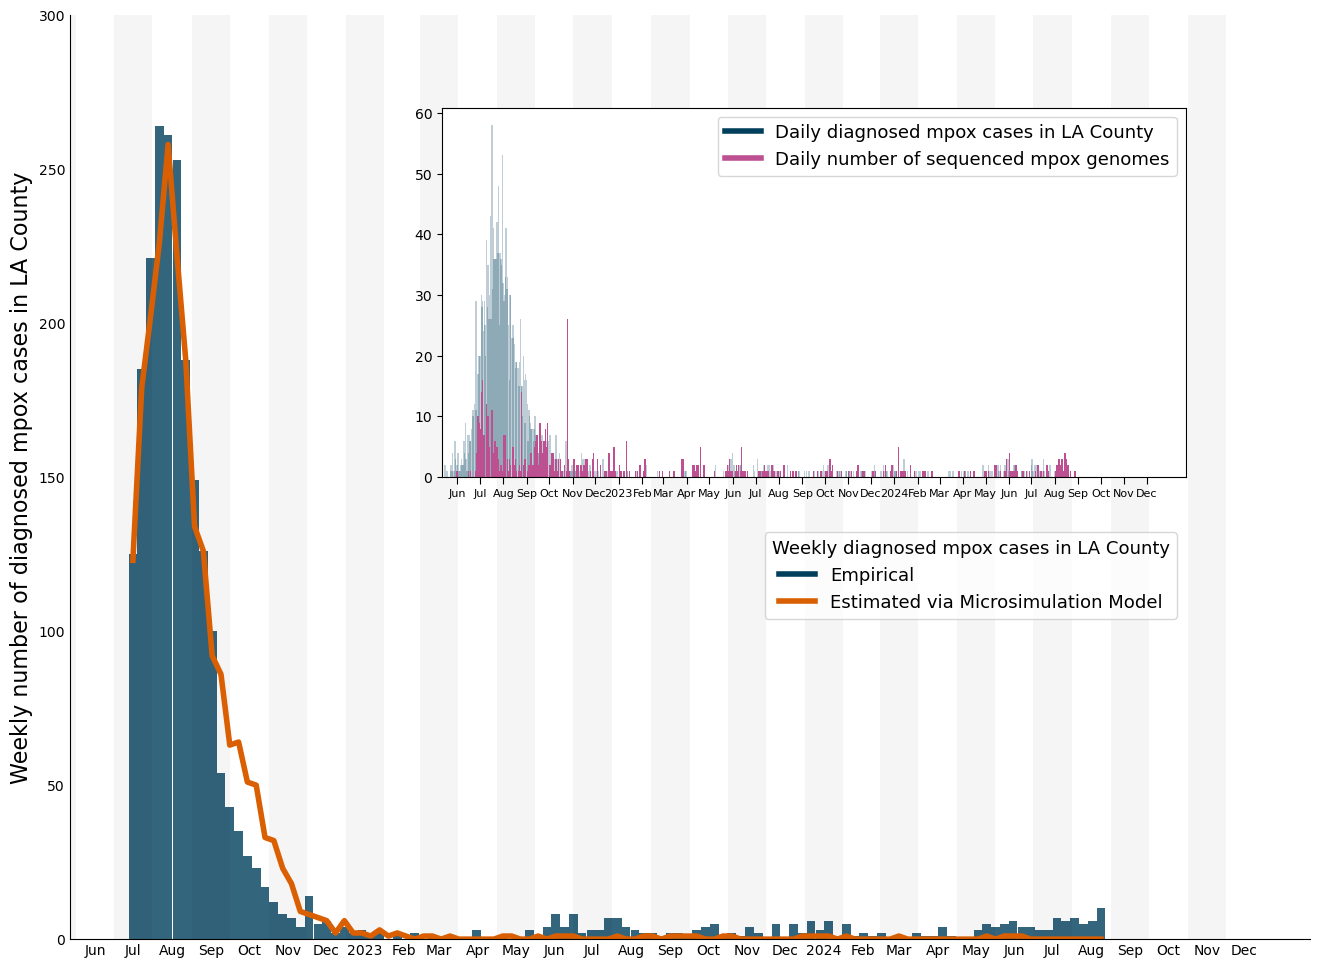

In [238]:
fig,ax = plt.subplots(figsize=(16,12),facecolor='w')

ins_ax = ax.inset_axes([.3, .5, .6, .4])  # [x, y, width, height] w.r.t. ax
    
# set blank white face for background    
ax.set_facecolor('white')
# remove grid 
ax.grid(False)

ax.bar(sim_df.decimal_date, sim_df["Empirical # of diagnosed cases"], color="#003f5c", alpha = 0.8, width = 0.019)
ax.plot(sim_df.decimal_date, sim_df["Model (FoI=1) diagnosed cases"], color="#d95f02", linewidth = 4, )


    #ax.plot([values.chain_tmrca, values.chain_latest_tip], [0, clust], color=col, linewidth=1, linestyle = ":")

   # ax.plot([mrca[0], mrca[1]], [clust, clust], color=col, linewidth=linewidth)
    # add small vertical lines at the start and end of each mrca
    # ax.plot([mrca[0], mrca[0]], [clust-0.2, clust+0.2], color=col, linewidth=1)
    # ax.plot([mrca[1], mrca[1]], [clust-0.2, clust+0.2], color=col, linewidth=1)

# # set ylabel, with a long arrow at the end
ax.set_ylabel('Weekly number of diagnosed mpox cases in LA County', fontsize=16)


# if values.date > 2022.99:

ins_ax.bar(la_mpox_cases_df.decimal_date,  la_mpox_cases_df.cases, color="#003f5c", alpha = 0.25, width = 0.005)
ins_ax.bar(sub_meta.decimal_date, sub_meta["count"], color="#bc5090", width = 0.005)

#plt.xticks([]); plt.yticks([])  # strip ticks, which collide w/ main ax


legend_list = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Empirical'),
                mlines.Line2D([0], [0], color="#d95f02", lw=4, label='Estimated via Microsimulation Model'),]
ax.legend(handles=legend_list, title='Weekly diagnosed mpox cases in LA County', fontsize=13, title_fontsize=13, bbox_to_anchor=(0.4, -0.05, 0.5, 0.5))

legend_list_inset = [mlines.Line2D([0], [0], color="#003f5c", lw=4, label='Daily diagnosed mpox cases in LA County'),
                mlines.Line2D([0], [0], color="#bc5090", lw=4, label='Daily number of sequenced mpox genomes'),]
ins_ax.legend(handles=legend_list_inset, title='', fontsize=13, title_fontsize=13, loc = "upper right")
xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]
xDates2=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]


every=1
[ax.axvspan(bt.decimalDate(xDates2[x]),bt.decimalDate(xDates2[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates2),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=10,size=0)  


ins_ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ins_ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ins_ax.tick_params(axis='x',labelsize=8,size=5)  

#ax1.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right']]

ax.tick_params(axis='y',size=0)
#ax.set_yticklabels([])
ax.set_ylim(0,300)
ax.set_xlim(2022.4,2025.1)
ins_ax.set_xlim(2022.4,2025.1)


ax.xaxis.set_tick_params(which='both', top=False, bottom=True, labelbottom=True)
ax.yaxis.set_tick_params(which='both', right=False, left=True, labelleft=True)
plt.savefig('../figures/descriptive_epi.png',dpi=300,bbox_inches='tight')


In [82]:
count_clusters = sub_meta.groupby('cluster')["strain"].count().reset_index()
sub_meta = sub_meta.merge(count_clusters, on = "cluster")
sub_meta = sub_meta.rename(columns={"strain_x": "strain", "strain_y": "size_of_cluster"}); sub_meta

,strain,cluster,location,date,lineage,year_month,year,year-week,size_of_cluster
0,OQ330970,1,Los Angeles County,2022-08-19,B.1,2022-08,2022,2022-08-15,2
1,OP442542,1,Los Angeles County,2022-08-18,B.1,2022-08,2022,2022-08-15,2
2,OP920688,2,Los Angeles County,2022-10-11,B.1,2022-10,2022,2022-10-10,1
3,OP539896,3,Los Angeles County,2022-09-01,B.1,2022-09,2022,2022-08-29,1
4,OP615263,4,Los Angeles County,2022-07-17,B.1,2022-07,2022,2022-07-11,1
...,...,...,...,...,...,...,...,...,...
683,PQ059896,271,Los Angeles County,2024-06-17,B.1.20,2024-06,2024,2024-06-17,3
684,PP918963,272,Los Angeles County,2024-05-28,B.1.20,2024-05,2024,2024-05-27,3
685,PQ207094,272,Los Angeles County,2024-07-24,B.1.20,2024-07,2024,2024-07-22,3
686,PQ358792,272,Los Angeles County,2024-08-22,B.1.20,2024-08,2024,2024-08-19,3


In [237]:
date_clus = sub_meta.groupby('cluster').first().reset_index()#; date_clus
variant_date_df = date_clus.groupby(["year_month"])["size_of_cluster"].mean().reset_index(); variant_date_df.head()


,year_month,size_of_cluster
0,2022-06,1.000000
1,2022-07,2.287500
2,2022-08,2.285714
3,2022-09,1.333333
4,2022-10,2.645161


In [86]:
clust_over_time =  alt.Chart(date_clus).mark_bar(opacity = 0.75, interpolate='monotone', size =10).encode(
    alt.X('size_of_cluster', axis = alt.Axis(grid= False,  title="size of Local Outbreak Clusters")),
    alt.Y('count():Q', axis=alt.Axis(title="count", grid=False, labelFontSize = 14), stack = None),
    alt.Color("year")
).properties(
    width=500,
    height=300
)
clust_over_time

alt.Chart(...)

In [88]:
clust_over_time =  alt.Chart(date_clus).mark_bar(opacity = 0.75, interpolate='monotone', size =10).encode(
    alt.X('size_of_cluster', axis = alt.Axis(grid= False,  title = "")),
    alt.Y('count():Q', axis=alt.Axis(title="Number of Local Outbreak Clusters", grid=False, labelFontSize = 14), stack = None),
    alt.Color("year")
).transform_filter(datum.size_of_cluster > 7
).properties(
    width=500,
    height=300
)
clust_over_time

alt.Chart(...)

In [105]:
clust_over_time =  alt.Chart(date_clus).mark_bar(opacity = 1, interpolate='monotone', size = 10).encode(
    alt.X('year_month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('count():Q', axis=alt.Axis(title="Number of Local Outbreak Clusters", grid=False, labelFontSize = 14), stack = None), 
).properties(
    width=300,
    height=200
)
clust_over_time

alt.Chart(...)

In [106]:
clust_size_over_time =  alt.Chart(variant_date_df).mark_bar(opacity = 1, interpolate='monotone',size = 10).encode(
    alt.X('year_month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('size_of_cluster:Q', axis=alt.Axis(title="Mean Size of Local Outbreak Clusters", grid=False, labelFontSize = 14,), stack = None), 
   
).properties(
    width=300,
    height=200
)#.transform_filter(datum.size_of_cluster <10)


clust_size_over_time

alt.Chart(...)

In [107]:
clust_over_time | clust_size_over_time

alt.HConcatChart(...)

In [92]:
la_mpox_cases_df = pd.read_csv("../scripts/monkeypox_data.csv")
la_mpox_cases_df = la_mpox_cases_df.dropna(how = "all").dropna(axis = "columns", how = "all")
la_mpox_cases_df = la_mpox_cases_df.rename(columns= {"Unnamed: 0": "date"}); la_mpox_cases_df.head()

,date,cases
0,2022-05-19,1
1,2022-05-20,0
2,2022-05-21,0
3,2022-05-22,0
4,2022-05-23,0


In [93]:
la_mpox_cases_df["year_month"] = la_mpox_cases_df['date'].str.rsplit("-", 1).str[-0].tolist()
monthly_cases = la_mpox_cases_df.groupby("year_month")["cases"].sum().reset_index()

In [94]:
monthly_case_plot =  alt.Chart(monthly_cases).mark_line(opacity = 1,  color = "orange").encode(
    alt.X('year_month:T', axis = alt.Axis(grid= False, format = "%B %Y", title = "")),
    alt.Y('cases:Q', axis=alt.Axis(title="Mean Size of Local Outbreak Clusters", grid=False, labelFontSize = 14,), stack = None), 
   
).properties(
    width=300,
    height=200
)

(monthly_case_plot + clust_over_time).resolve_scale(y= "independent")

alt.LayerChart(...)